In [1]:
import os
import json

# Create an empty list to store the dictionaries
json_data_list = []

# Directory where your JSON files are located
json_files_directory = '../../DataEng/datalake/bronze'

# Loop through each JSON file in the directory
for filename in os.listdir(json_files_directory):
    if filename.startswith('data_') and filename.endswith('.json'):
        # Construct the full path to the JSON file
        file_path = os.path.join(json_files_directory, filename)

        # Open and read the JSON file
        with open(file_path, 'r') as json_file:
            # Load the JSON data into a dictionary
            json_data = json.load(json_file)

            # Create a new dictionary to hold both the file name and JSON data
            json_with_filename = {
                'filename': filename,  # Save the file name
                'data': json_data     # Save the JSON data
            }

            # Append the dictionary to the list
            json_data_list.append(json_with_filename)

# Now, json_data_list contains a list of dictionaries, where each dictionary has a 'filename' key
# with the name of the JSON file and a 'data' key with the JSON data from that file for files starting with 'data_'.


import pandas as pd


# Create a DataFrame
df = pd.DataFrame(json_data_list)

# If you want to flatten the 'data' dictionary into separate columns:
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)

# Now, df contains your data in a Pandas DataFrame format
df

# Extract and transform the 'filename' column into a timestamp column
df['timestamp'] = pd.to_datetime(df['filename'].str.extract(r'data_(\d{14})\.json')[0], format='%Y%m%d%H%M%S')

# Drop the 'filename' column if no longer needed
df = df.drop('filename', axis=1)

# Now, df contains a 'timestamp' column extracted from the 'filename'
df.head()

#save df to csv on the silver layer name ghanor
df.drop(columns=['targetAmount', 'targetDate']).to_csv('../../DataEng/datalake/silver/ghanor.csv', index=False)

In [2]:
#read ghanor file on ../../DataEng/datalake/silver/ghanor.csv
import pandas as pd

df = pd.read_csv('../../DataEng/datalake/silver/ghanor.csv', sep=',')
df.head()

,raisedAmount,supporters,timestamp
0,5148832.0,5032,2023-10-10 08:24:03
1,4731772.0,4495,2023-10-08 21:07:04
2,4847103.0,4650,2023-10-08 22:24:04
3,5675196.0,5324,2023-10-15 17:46:04
4,5639204.0,5286,2023-10-14 13:53:04


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

#order by timestamp
df = df.sort_values(by=['timestamp'], ascending=False)
df.head(10)

,raisedAmount,supporters,timestamp
109,5750726.0,5409,2023-10-17 15:21:04
3389,5750726.0,5409,2023-10-17 15:20:04
4130,5750726.0,5409,2023-10-17 15:19:03
5937,5750726.0,5409,2023-10-17 15:18:05
4764,5750452.0,5408,2023-10-17 15:17:04
1837,5750452.0,5408,2023-10-17 15:16:05
3248,5750452.0,5408,2023-10-17 15:15:05
4359,5750452.0,5408,2023-10-17 15:14:05
5594,5750452.0,5408,2023-10-17 15:13:04
5330,5749967.0,5407,2023-10-17 15:12:05


In [4]:
# analyze the data only from the last day column timestamp


#transform column timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
last_day = df['timestamp'].max().date()

last_day

#group data from last day

df_last_day = df[df['timestamp'].dt.date == last_day]
df_last_day

,raisedAmount,supporters,timestamp
109,5750726.0,5409,2023-10-17 15:21:04
3389,5750726.0,5409,2023-10-17 15:20:04
4130,5750726.0,5409,2023-10-17 15:19:03
5937,5750726.0,5409,2023-10-17 15:18:05
4764,5750452.0,5408,2023-10-17 15:17:04
...,...,...,...
2760,5733989.0,5386,2023-10-17 00:04:03
6270,5733989.0,5386,2023-10-17 00:03:04
3276,5733989.0,5386,2023-10-17 00:02:04
1335,5733989.0,5386,2023-10-17 00:01:04


In [5]:
df_last_day.head(20)

,raisedAmount,supporters,timestamp
109,5750726.0,5409,2023-10-17 15:21:04
3389,5750726.0,5409,2023-10-17 15:20:04
4130,5750726.0,5409,2023-10-17 15:19:03
5937,5750726.0,5409,2023-10-17 15:18:05
4764,5750452.0,5408,2023-10-17 15:17:04
1837,5750452.0,5408,2023-10-17 15:16:05
3248,5750452.0,5408,2023-10-17 15:15:05
4359,5750452.0,5408,2023-10-17 15:14:05
5594,5750452.0,5408,2023-10-17 15:13:04
5330,5749967.0,5407,2023-10-17 15:12:05


In [6]:
#create columns with diff raisedAmount and first raisedAmount
df_last_day['diff_raisedAmount'] = df_last_day['raisedAmount'] - df_last_day['raisedAmount'].iloc[-1]

#the same but for the supporters
df_last_day['diff_supporters'] = df_last_day['supporters'] - df_last_day['supporters'].iloc[-1]

/tmp/ipykernel_2602/1427054642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_day['diff_raisedAmount'] = df_last_day['raisedAmount'] - df_last_day['raisedAmount'].iloc[-1]
/tmp/ipykernel_2602/1427054642.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_day['diff_supporters'] = df_last_day['supporters'] - df_last_day['supporters'].iloc[-1]


In [7]:
df_last_day['diff_raisedAmount']

109     16737.0
3389    16737.0
4130    16737.0
5937    16737.0
4764    16463.0
         ...   
2760        0.0
6270        0.0
3276        0.0
1335        0.0
4949        0.0
Name: diff_raisedAmount, Length: 333, dtype: float64

<Axes: xlabel='timestamp'>

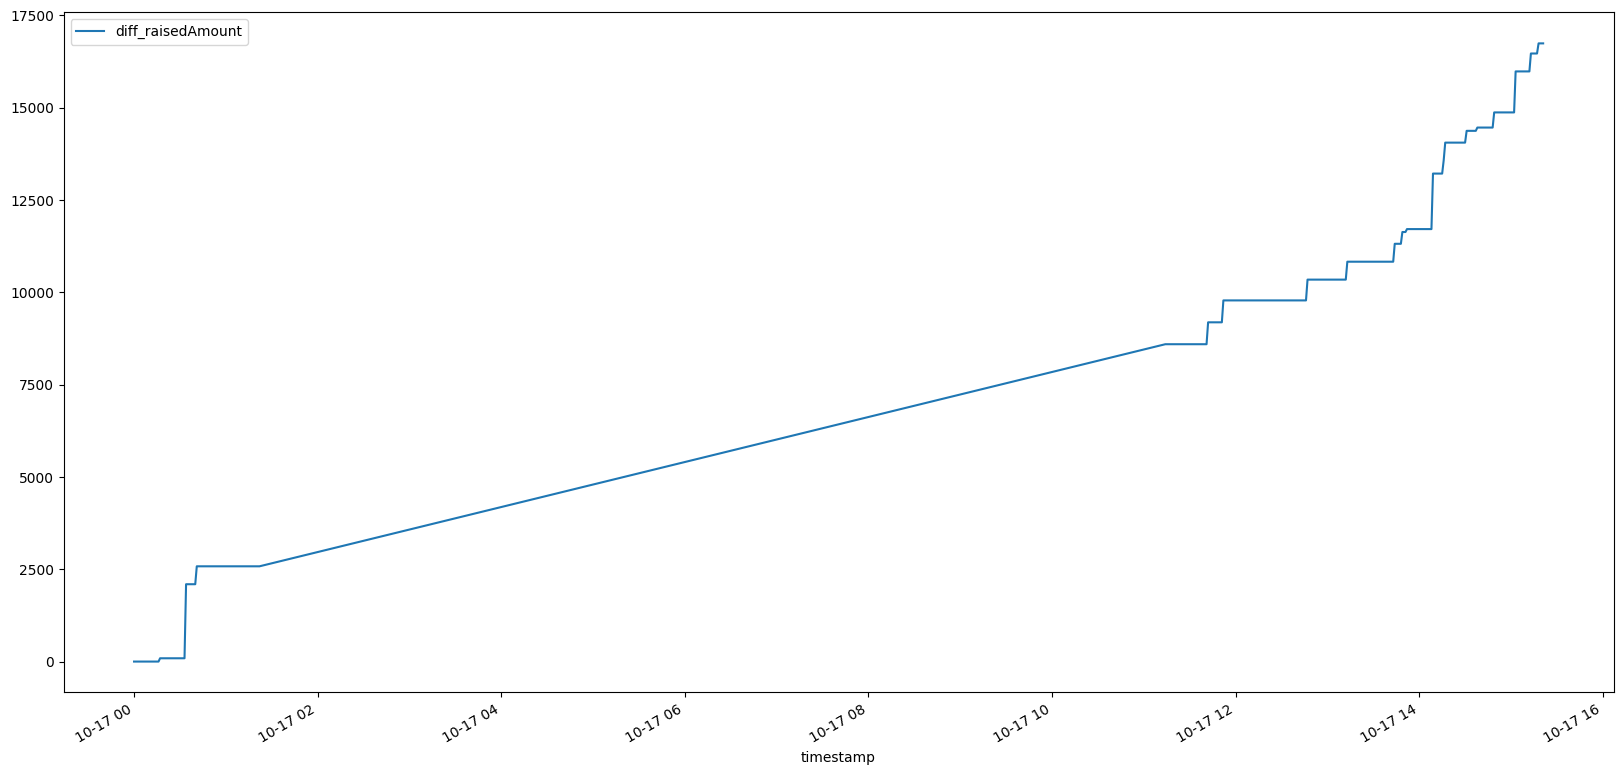

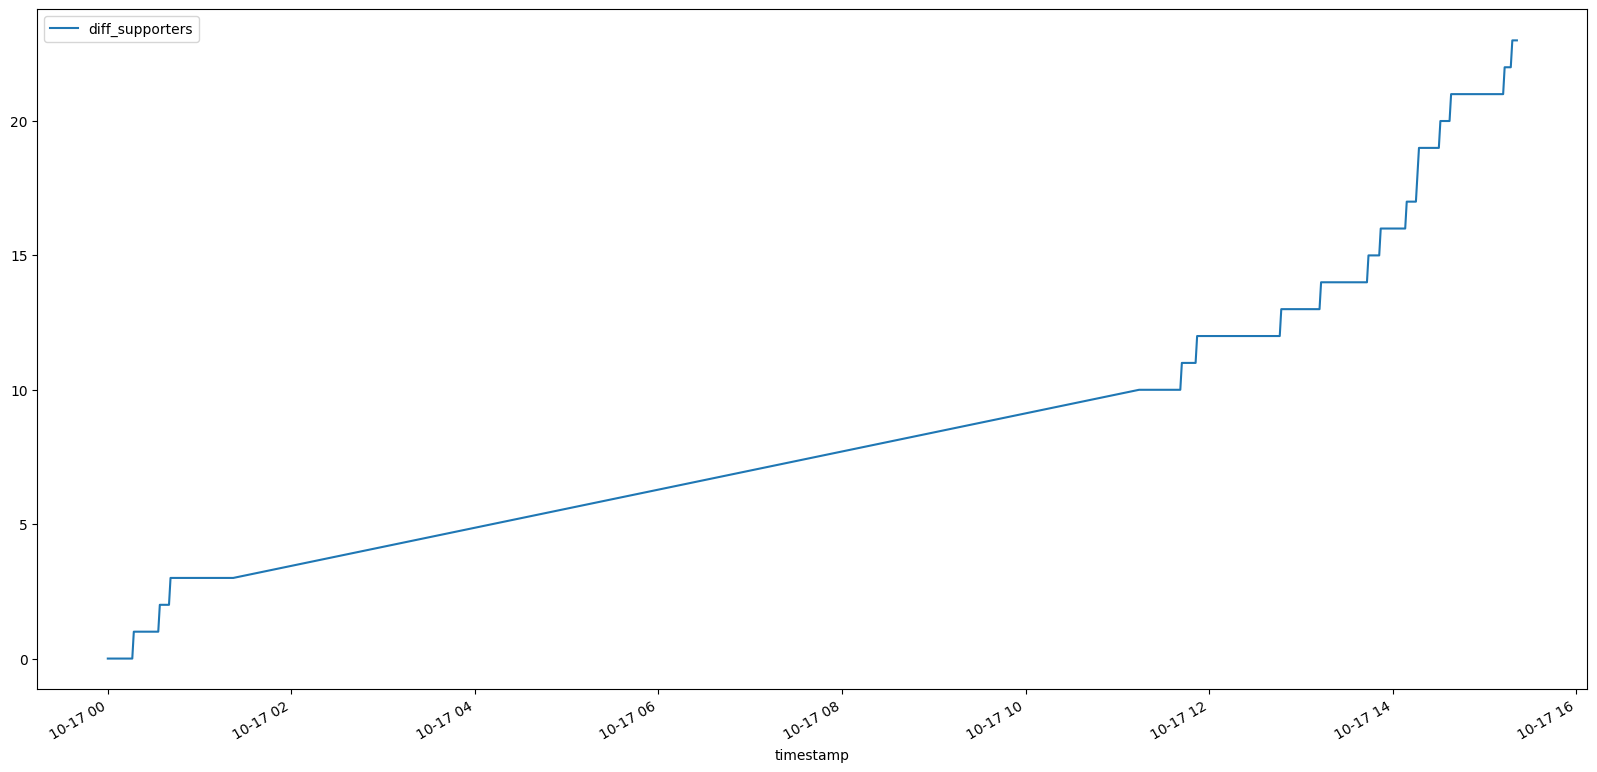

In [8]:
df_last_day.plot(x='timestamp', y='diff_raisedAmount', kind='line', figsize=(20, 10))
df_last_day.plot(x='timestamp', y='diff_supporters', kind='line', figsize=(20, 10))

In [9]:
#transform column timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
#  select data from date 10/10/2023
df_2023 = df[df['timestamp'].dt.date == pd.to_datetime('2023-10-10').date()]
df_2023

,raisedAmount,supporters,timestamp
4708,5450447.0,5105,2023-10-10 23:11:04
2065,5449962.0,5104,2023-10-10 23:10:04
1699,5449962.0,5104,2023-10-10 23:09:04
904,5449962.0,5104,2023-10-10 23:08:04
5132,5449962.0,5104,2023-10-10 23:07:03
...,...,...,...
245,5140189.0,5022,2023-10-10 00:04:03
5434,5140189.0,5022,2023-10-10 00:03:04
1722,5140189.0,5022,2023-10-10 00:02:04
6201,5140189.0,5022,2023-10-10 00:01:03


In [11]:
#create columns with diff raisedAmount and first raisedAmount
df_2023['diff_raisedAmount'] = df_2023['raisedAmount'].iloc[-1] - df_2023['raisedAmount']

#the same but for the supporters
df_2023['diff_supporters'] = df_2023['supporters'].iloc[-1] - df_2023['supporters'] 

/tmp/ipykernel_2602/2370981286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['diff_raisedAmount'] = df_2023['raisedAmount'].iloc[-1] - df_2023['raisedAmount']
/tmp/ipykernel_2602/2370981286.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['diff_supporters'] = df_2023['supporters'].iloc[-1] - df_2023['supporters']


In [12]:
df_2023['raisedAmount'].iloc[0] - df_2023['raisedAmount'].iloc[0]

0.0

In [13]:
df_2023['raisedAmount'].iloc[0] - df_2023['raisedAmount'].iloc[1]

485.0

In [14]:
df_2023['supporters'].iloc[0] - df_2023['supporters'].iloc[0]

0

In [15]:
df_2023['supporters'].iloc[1] - df_2023['supporters'].iloc[0]

-1

<Axes: xlabel='timestamp'>

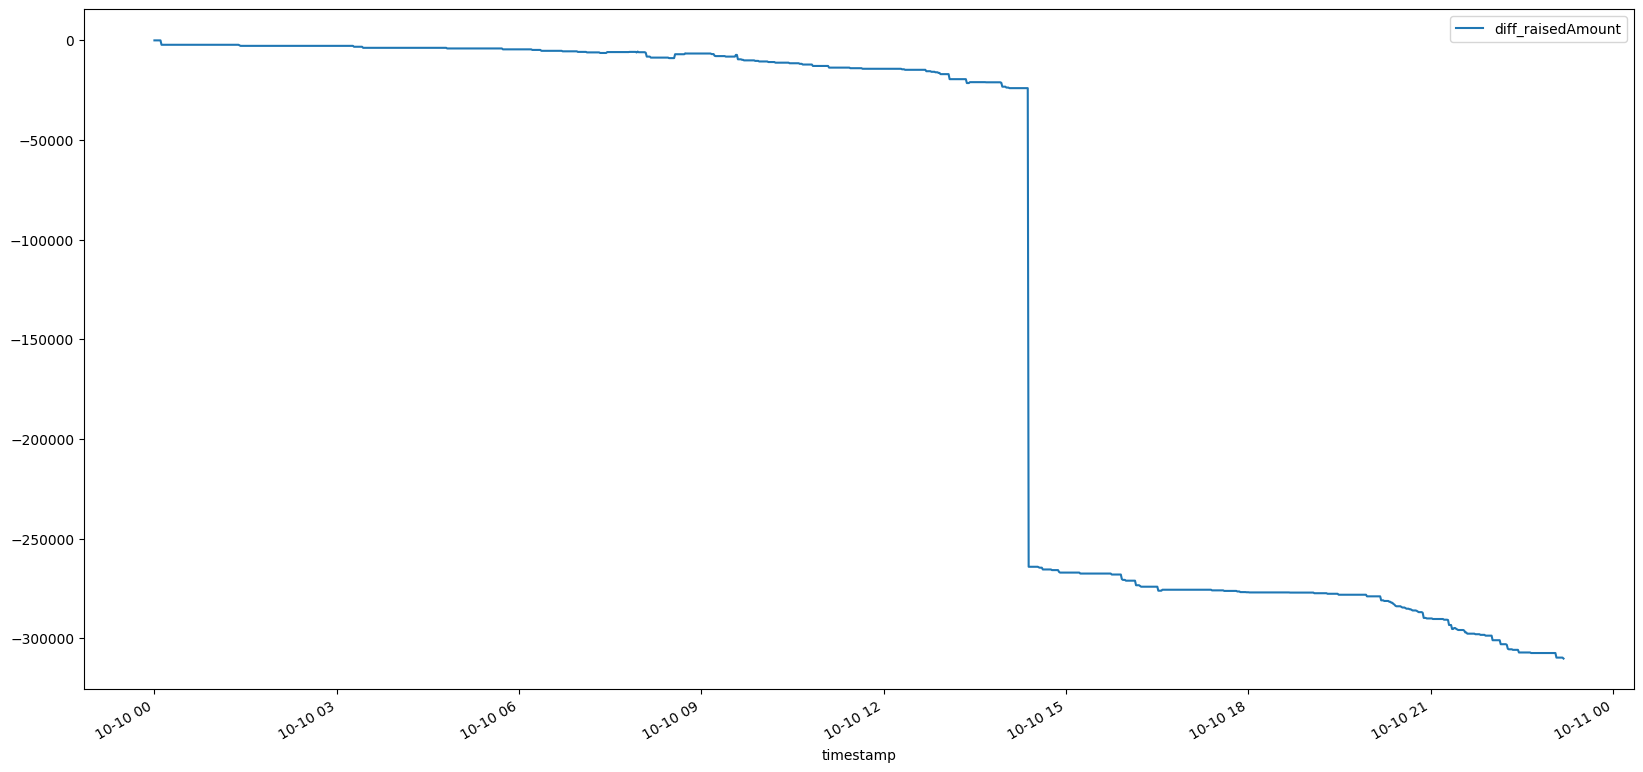

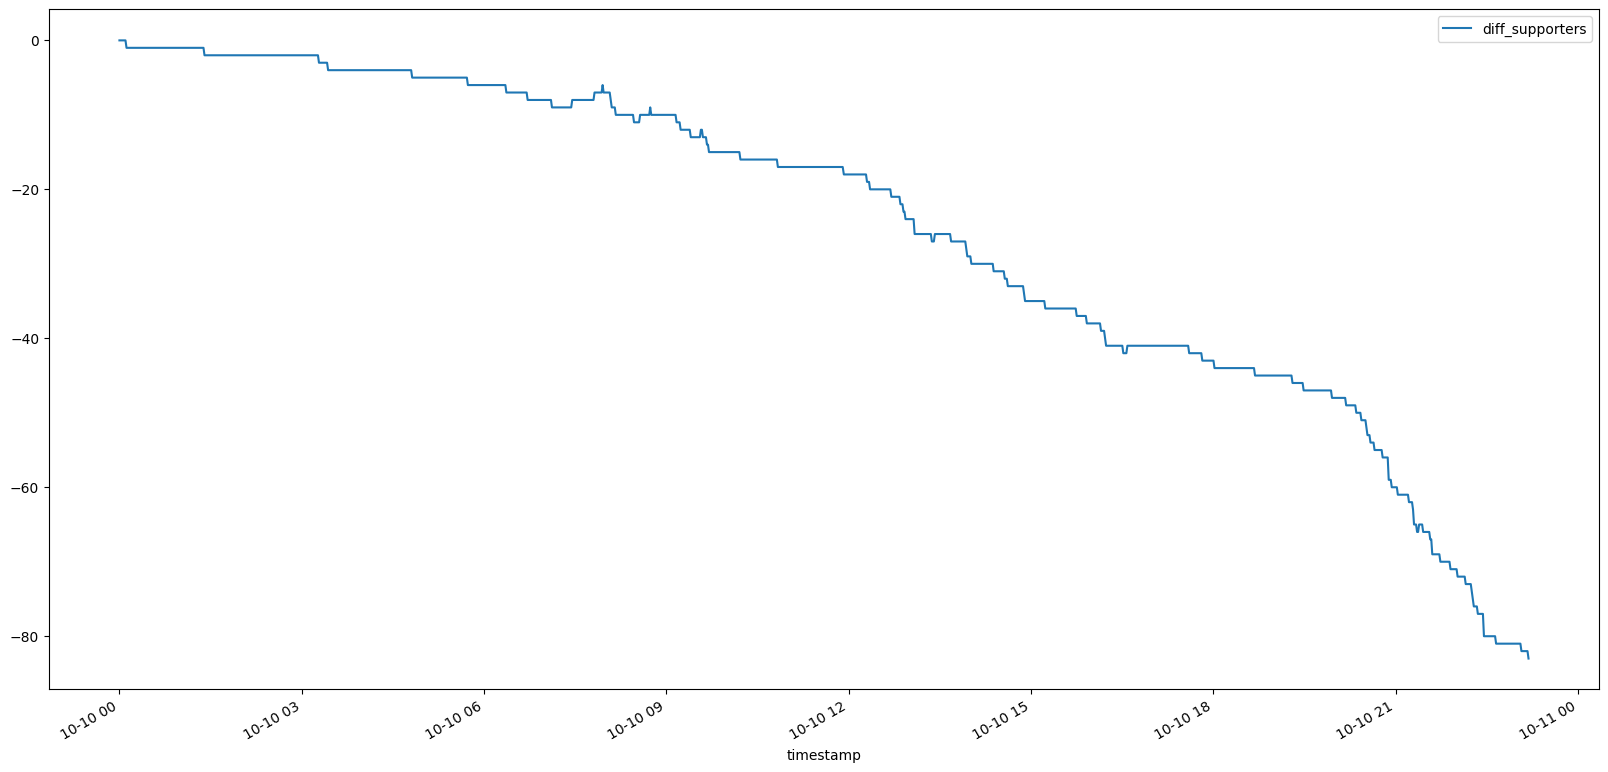

In [16]:
df_2023.plot(x='timestamp', y='diff_raisedAmount', kind='line', figsize=(20, 10))
df_2023.plot(x='timestamp', y='diff_supporters', kind='line', figsize=(20, 10))